<a href="https://colab.research.google.com/github/thonnh/PINN/blob/main/PINN_with_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
%reset -f
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def exact_solution(L, E, I, q, x):
    "Defines the analytical solution to the Euler-Bernoulli beam problem."
    u = ((q*x**4)-(4*q*L*x**3)+(6*q*L**2*x**2))/(24*E*I)
    return u

class FCN(nn.Module):
    "Defines a standard fully-connected network in PyTorch"

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

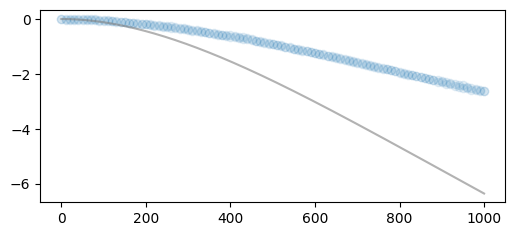

In [99]:
# compare EB solution with FEM
L = 1000    #mm
E = 200     #GPa
I = 98331.9 #mm^4
q = -0.001  #kN/mm

x = np.linspace(0,1000,500)
u = exact_solution(L, E, I, q, x)

df_coor = pd.read_csv('coor.csv')
tolerance = 1 # filter only at y = 0
filtered_df = df_coor[abs(df_coor['Y Location (mm)']) < tolerance]
data_x = filtered_df['LOC_DEFX (mm)']
data_y = filtered_df['LOC_DEFY (mm)']

plt.figure(figsize=(6,2.5))
plt.plot(x[:], u[:], label="Exact solution", color="tab:grey", alpha=0.6)
plt.scatter(data_x[:], data_y[:], label="Exact solution", color="tab:blue", alpha=0.1)

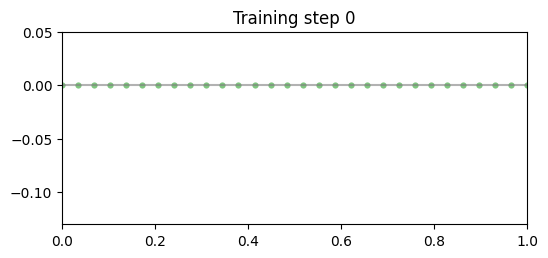

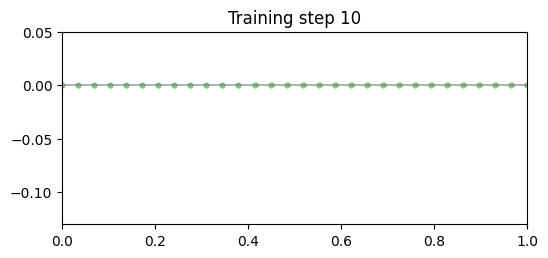

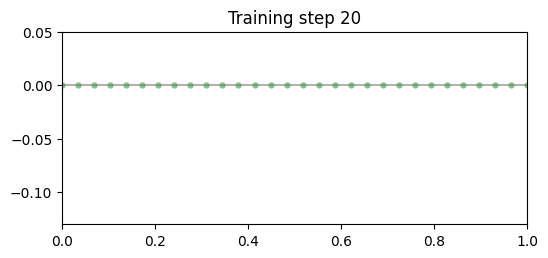

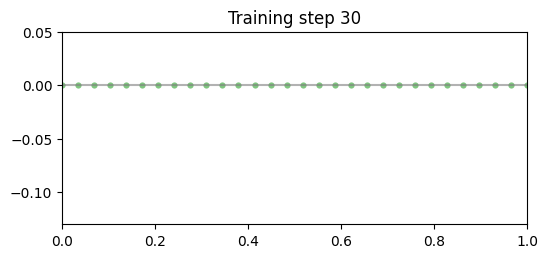

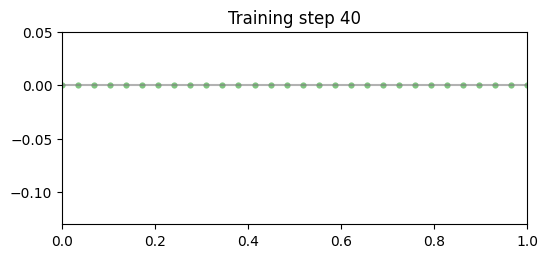

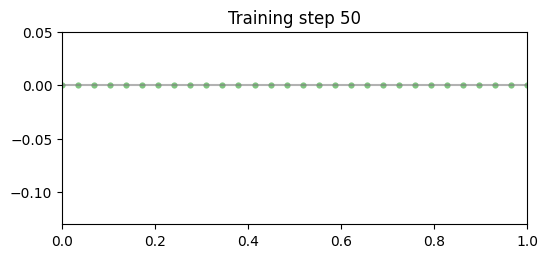

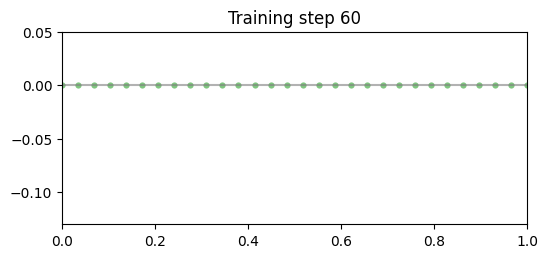

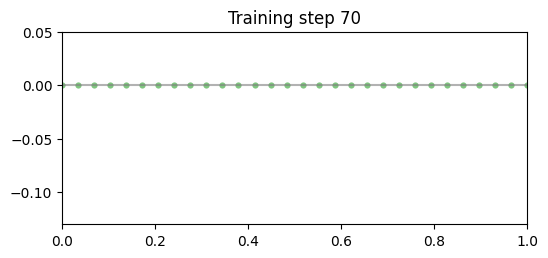

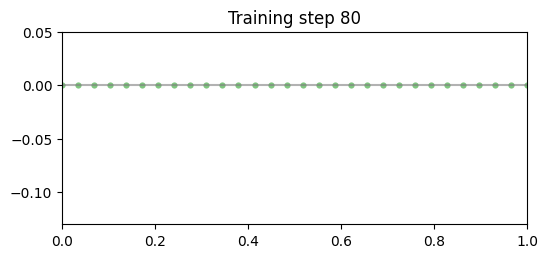

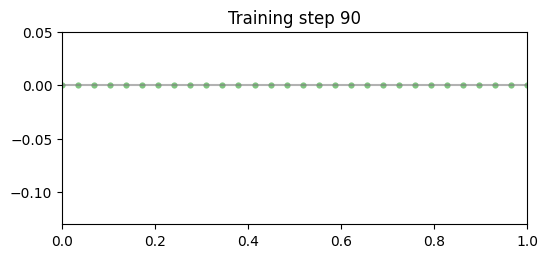

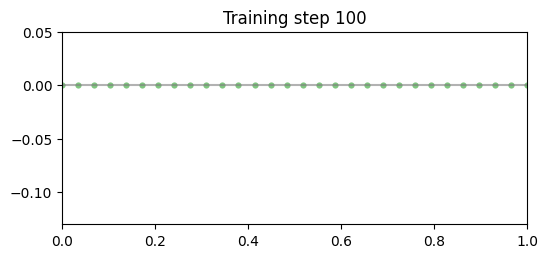

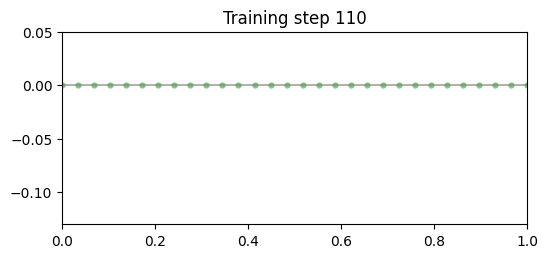

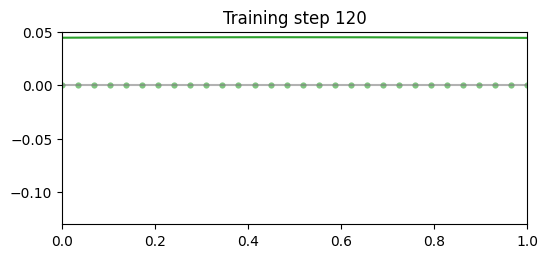

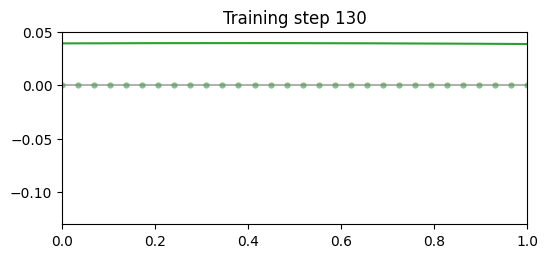

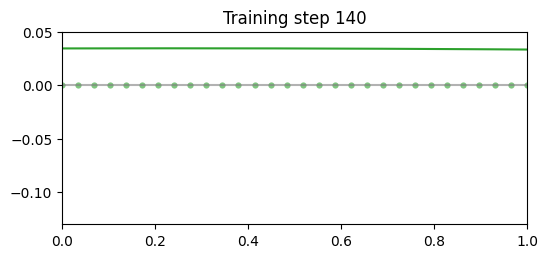

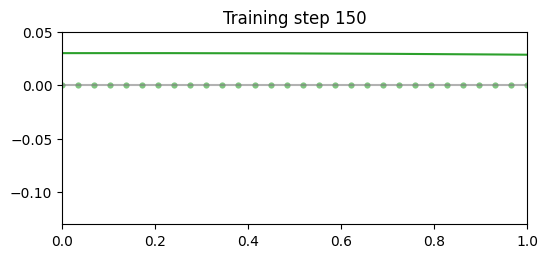

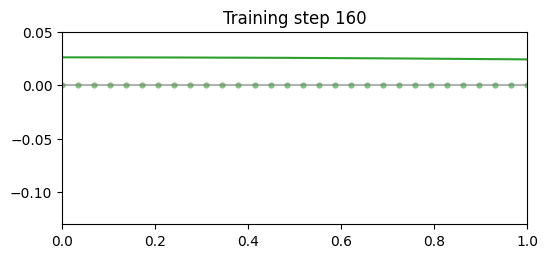

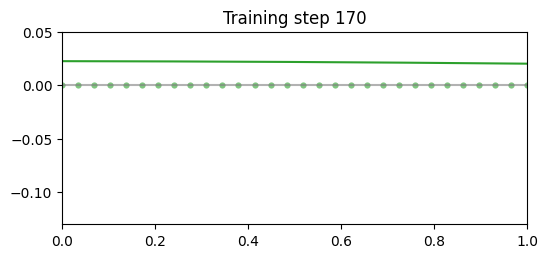

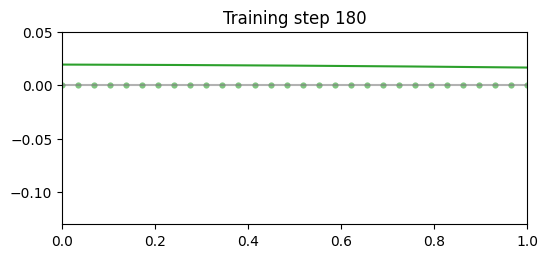

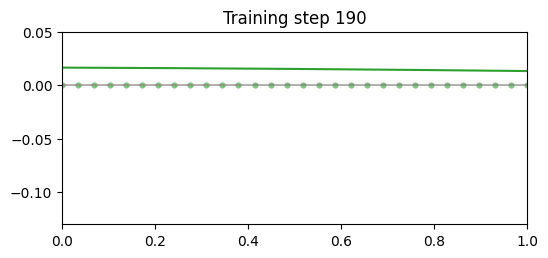

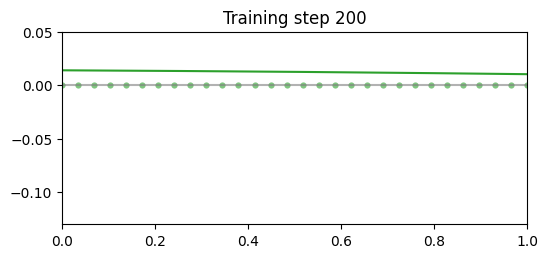

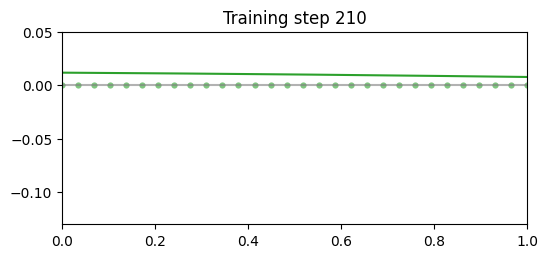

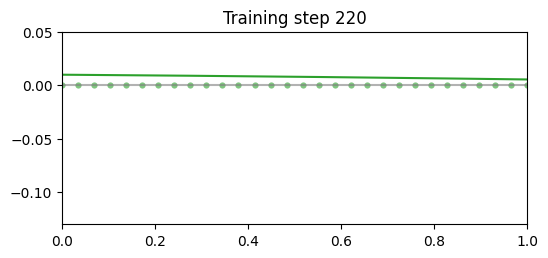

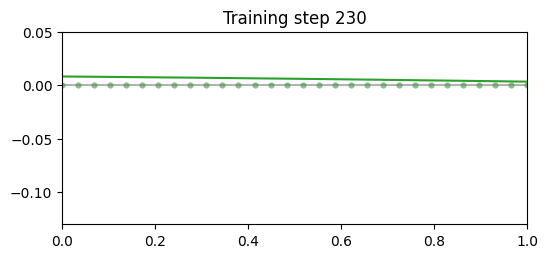

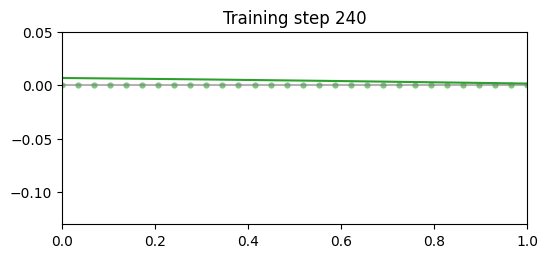

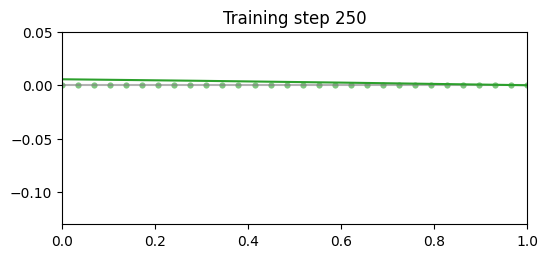

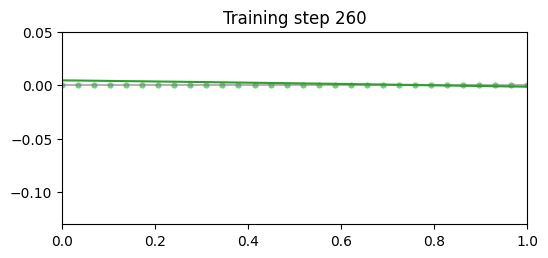

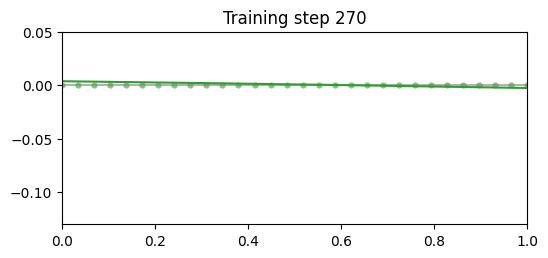

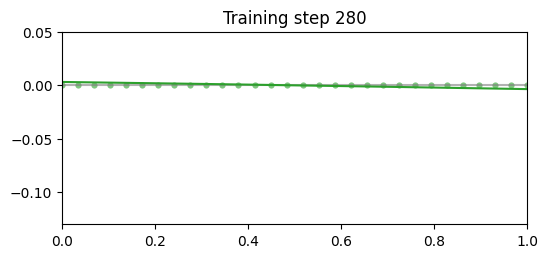

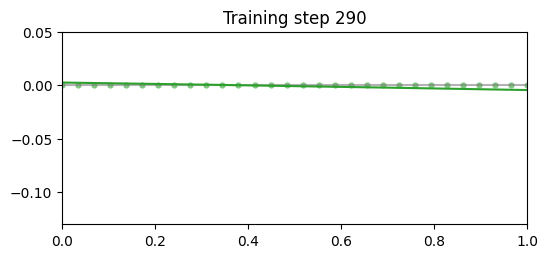

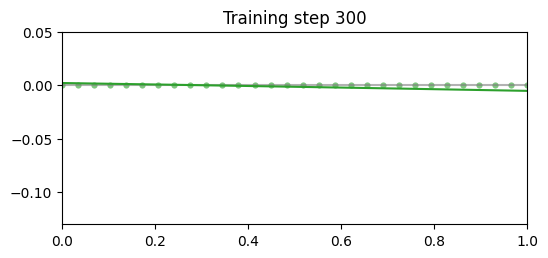

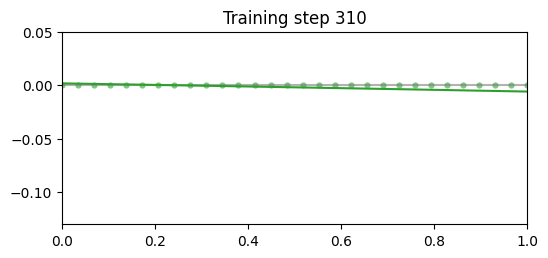

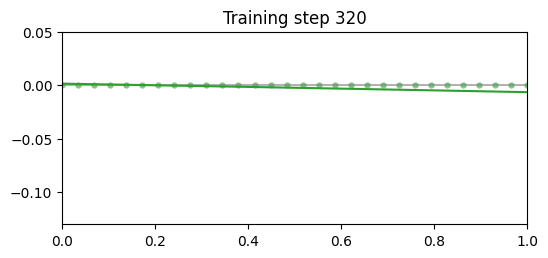

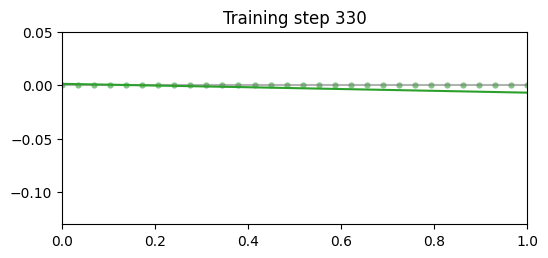

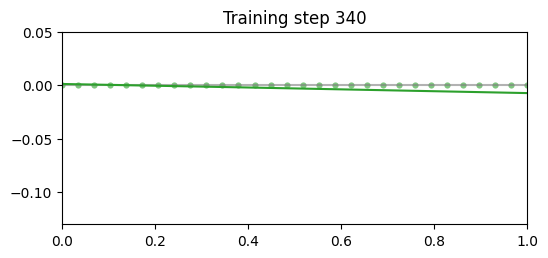

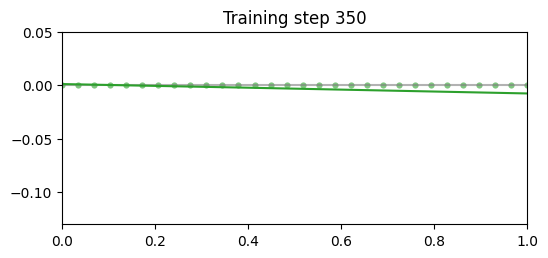

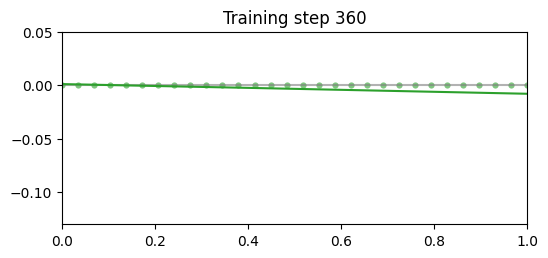

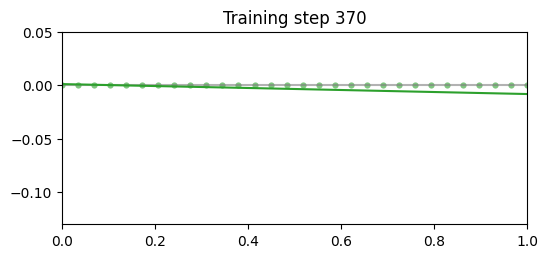

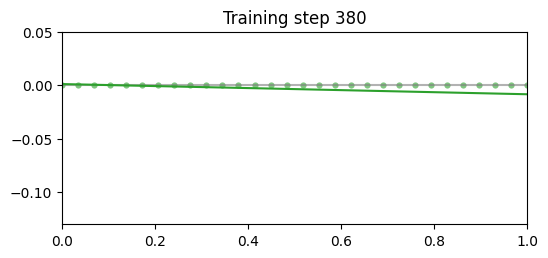

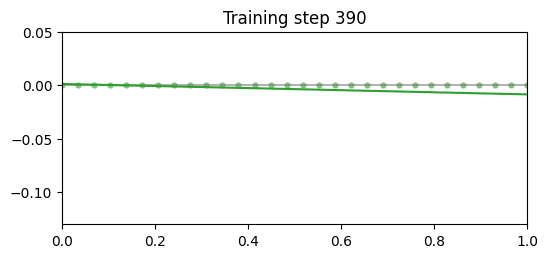

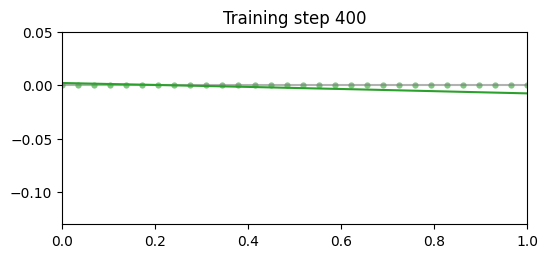

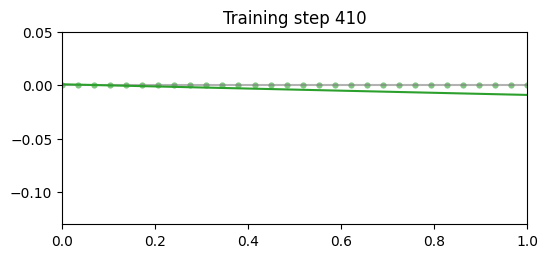

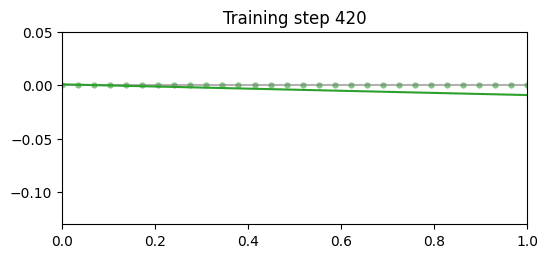

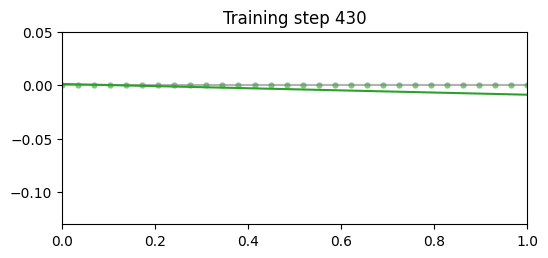

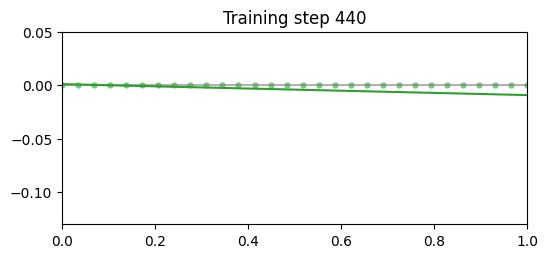

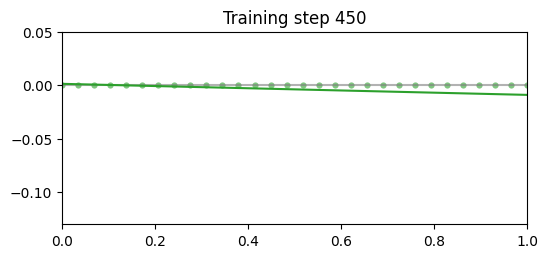

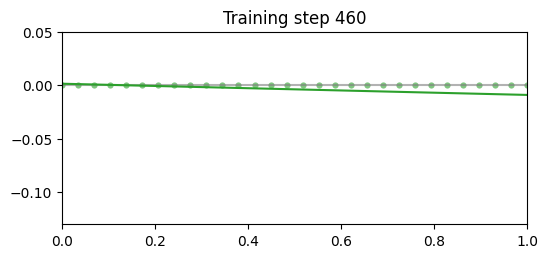

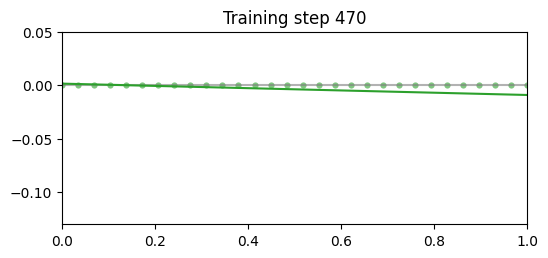

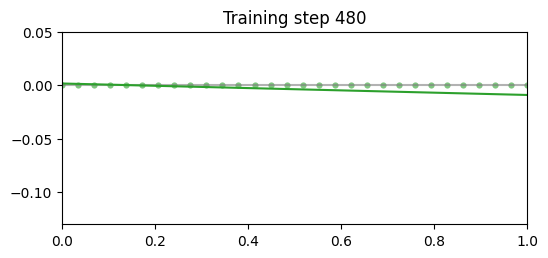

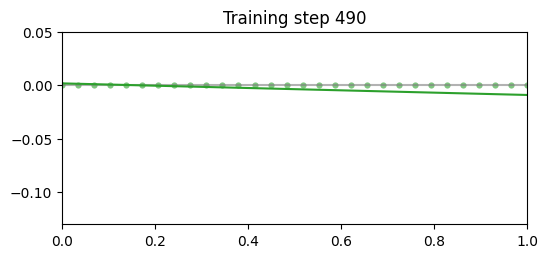

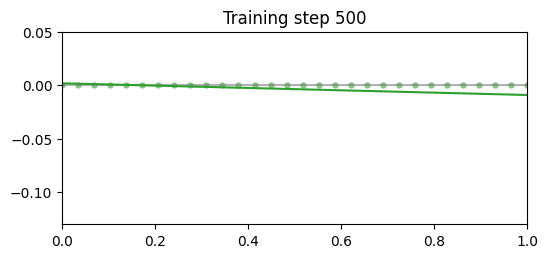

In [102]:
# define a neural network to train
pinn = FCN(1,1,64,3)

# define boundary points, for the boundary loss
x_bc0 = torch.tensor(0.).view(-1,1).requires_grad_(True)
x_bcL = torch.tensor(1.).view(-1,1).requires_grad_(True)

# define training points over the entire domain, for the physics loss
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# define normalize x, y data from FEM
x_fem = torch.tensor(data_x / 1000, dtype=torch.float32).view(-1, 1).requires_grad_(True)
y_fem = torch.tensor(data_y / 1000, dtype=torch.float32).view(-1, 1).requires_grad_(True)

# train the PINN
x_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(L, E, I, q, x_test)
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-3)

iteration = 501
# Initialize arrays to store losses
losses1 = np.zeros(iteration)
losses2 = np.zeros(iteration)
losses3 = np.zeros(iteration)
losses4 = np.zeros(iteration)
losses5 = np.zeros(iteration)
losses6 = np.zeros(iteration)

for i in range(iteration):
    optimiser.zero_grad()

    # compute boundary loss at x = 0
    u = pinn(x_bc0) # (1,1)
    loss1 = (torch.squeeze(u) - 0)**2

    dudt = torch.autograd.grad(u, x_bc0, torch.ones_like(u), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2

    # compute boundary loss at x = L
    u = pinn(x_bcL) # (1,1)
    dudt = torch.autograd.grad(u, x_bcL, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, x_bcL, torch.ones_like(u), create_graph=True)[0]
    d3udt3 = torch.autograd.grad(d2udt2, x_bcL, torch.ones_like(u), create_graph=True)[0]

    loss3 = (torch.squeeze(d2udt2) - 0)**2
    loss4 = (torch.squeeze(d3udt3) - 0)**2

    # compute physics loss
    u = pinn(x_physics)
    dudt = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, x_physics, torch.ones_like(dudt), create_graph=True)[0]
    d3udt3 = torch.autograd.grad(d2udt2, x_physics, torch.ones_like(dudt), create_graph=True)[0]
    d4udt4 = torch.autograd.grad(d3udt3, x_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss5 = torch.mean((E*I*d4udt4 - q )**2)

    # compute data loss from FEM
    u = pinn(x_fem)
    loss6 = torch.mean(u - y_fem)**2

    # Store the losses
    losses1[i] = loss1.item()
    losses2[i] = loss2.item()
    losses3[i] = loss3.item()
    losses4[i] = loss4.item()
    losses5[i] = loss5.item()
    losses6[i] = loss6.item()

    # backpropagate joint loss, take optimiser step
    loss = loss1 + loss2 + loss3 + loss4 + loss5 + loss6
    loss.backward()
    optimiser.step()

    # plot the result as training progresses
    if i % 10 == 0:
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = pinn(x_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(x_physics.detach()[:,0],
                    torch.zeros_like(x_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.plot(x_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(x_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        #plt.legend()
        plt.xlim(0, 1)
        plt.ylim(-0.13,0.05 )
        plt.show()